<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Unsupervised_Similar_Images_Finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import tqdm
import shutil
import skimage
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

!pip install patool
import patoolib

IPython.display.clear_output()

#Part 1

In [ ]:
patoolib.extract_archive("/content/drive/MyDrive/reddit_files.rar", outdir="/content/data")

Path = './data/images/'
os.rename(f"./data/{os.listdir('./data')[0]}", Path)

IPython.display.clear_output()

In [ ]:
data = os.listdir(Path)
len(data)

2009

In [320]:
Path = './data/images/'
data = glob.glob(f'{Path}/*g')
videos = glob.glob(f'{Path}/*.mp4')
os.makedirs(f'{Path}/Videos/', exist_ok=True)
os.makedirs(f'{Path}/Images/', exist_ok=True)
for i, video_path in enumerate(videos):
    os.replace(video_path, f'{Path}/Videos/{i}.mp4')

In [321]:
def min_pooling(img, pad_size=20):
  image = abs(img[:, :, 0] - img[:, :, 1] - img[:, :, 2])
  max_pool_img = skimage.measure.block_reduce(image, (pad_size,pad_size), np.mean)
  return max_pool_img

In [322]:
arr = []
height_arr, weight_arr = [], []
for d in tqdm.tqdm(data):
  try:
      img = cv2.imread(d)
      height_arr.append(img.shape[0])
      weight_arr.append(img.shape[1])
      img = cv2.resize(img, (1000, 1000))
      img = min_pooling(img, pad_size=50)
      img = np.ravel(img)
      arr.append(img)
  except:
    print(d)

print('\n')
print('Height Mean:',np.mean(height_arr), 'Height Min:',np.min(height_arr), 'Height Max:',np.max(height_arr))
print('Weight Mean:',np.mean(weight_arr), 'Weight Min:',np.min(weight_arr), 'Weight Max:',np.max(weight_arr))

100%|██████████| 1970/1970 [01:12<00:00, 27.23it/s]



Height Mean: 1343.7598984771573 Height Min: 194 Height Max: 8598
Weight Mean: 1111.6837563451777 Weight Min: 149 Weight Max: 6144


In [323]:
# mae_arr = []
# for i, A in tqdm.tqdm(enumerate(arr)):
#   temp = []
#   mean_mae_arr = [(abs(A - b)).mean() for b in arr]
#   for j, mae in enumerate(mean_mae_arr):
#     if mae < 10:
#         temp.append(data[j])
#   mae_arr.append(temp)

In [324]:
mae_arr = []
for i, A in tqdm.tqdm(enumerate(arr)):
  mean_mae_arr = np.array([(abs(A - b)).mean() for b in arr])
  mae_arr.append(mean_mae_arr)

mae_arr = np.array(mae_arr)

1970it [00:35, 55.18it/s]


In [325]:
def categorize(arr):
  arr[arr <= 1] = 0
  arr[np.logical_and(arr > 1 , arr <= 10)] = 10
  arr[np.logical_and(arr > 10, arr <= 20)] = 20
  arr[np.logical_and(arr > 20, arr <= 30)] = 30
  arr[np.logical_and(arr > 30, arr <= 40)] = 40
  arr[arr > 40] = 100
  return arr

In [326]:
mae_arr = []
arr2 = []
arr3 = []
for i, A in tqdm.tqdm(enumerate(arr)):
  temp = []
  mean_mae_arr = np.array([(abs(A - b)).mean() for b in arr])
  # mean_mae_arr = categorize(mean_mae_arr)
  mean_mae = np.mean(mean_mae_arr)
  arr2.append(mean_mae_arr)
  arr3.append(mean_mae)
  for j, mae in enumerate(arr):
    temp.append(data[j])
  mae_arr.append(temp)

arr2 = np.array(arr2)

1970it [00:38, 51.24it/s]


In [329]:
temp_arr = []
score_arr= []
for score, path in zip(arr2, mae_arr):
  if len(np.unique(score)) > 2:
    t1, t2 = [], []
    for s, p in zip(score, path):
      if s < 50:
        t1.append(s)
        t2.append(p)
    score_arr.append(t1)
    temp_arr.append(t2)

len(temp_arr), len(arr2)

(1970, 1970)

In [ ]:
# N=0
N+=1
mae_pathes = np.array(temp_arr[N])[np.argsort(score_arr[N])]
mae_scores = np.array(score_arr[N])[np.argsort(score_arr[N])]
print(N, list(np.round(mae_scores[:5], 2)))
fig = plt.figure(figsize=(5, 5))
for i in range(20):
  img = plt.imread(mae_pathes[i])
  img = cv2.resize(img, (100, 100))
  fig.add_subplot(4, 5, i+1)
  plt.gca().set_title(round(mae_scores[i], 2))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)

100 99.94923857868021 100.0 (array([  0., 100.]), array([   1, 1969]))
100 [0.0, 100.0, 100.0, 100.0, 100.0]


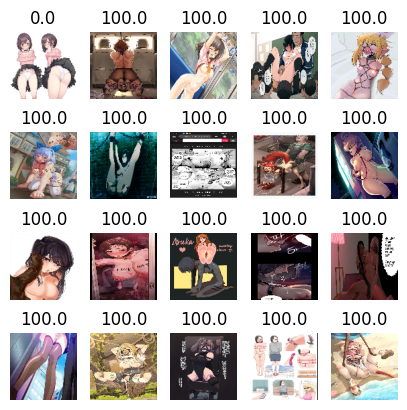

In [304]:
# N=0
N+=1
# 10 [0.0, 40.0 | 100.0, 100.0, 100.0]
# 18 [0.0, 0.0, 10.0, 10.0 | 100.0]
# 27 [0.0, 27.0, 28.45, 34.09 | 41]
# 28 [0.0, 3.69| 47.34]
# 29 [0.0, 0.77, 9.37, 9.38, 13.45, 13.55 | 52]
# 31 [0.0, 0.0, 0.13, 0.13| 33.55]
# 33 [0.0, 0.9, 3.21, 3.3, 3.75, 3.9 | 49]
# 38 [0.0, 0.93 | 28.42]
# 53 [0.0, 8.37, 16.78, 17.0 | 53.69]
# 58 [0.0, 0.0, 0.13, 0.13 | 33.54]
# 59 [0.0, 21.51, 27.0, 31.85 | 46.31]
# 61 [0.0, 1.35, 1.77, 1.87, 37.57, 37.87, 49.9]
# 88 [0.0, 10.0, 30.0, 30.0 | 100.0]
# 89 [0.0, 0.0 | 20.0, 30.0, 30.0]
# 94 [0.0, 10.0 | 100.0, 100.0, 100.0]
# 99 [0.0, 10.0, 40.0, 40.0 | 100.0]


print(N, arr3[N], np.max(arr2[N]), np.unique(arr2[N], return_counts=True))
mae_pathes = np.array(mae_arr[N])[np.argsort(arr2[N])]
mae_scores = np.array(arr2[N])[np.argsort(arr2[N])]
print(N, list(np.round(mae_scores[:5], 2)))
fig = plt.figure(figsize=(5, 5))
for i in range(20):
  img = plt.imread(mae_pathes[i])
  img = cv2.resize(img, (100, 100))
  fig.add_subplot(4, 5, i+1)
  plt.gca().set_title(round(mae_scores[i], 2))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)

In [ ]:
plt.figure(figsize=(2^16, 2^16))
plt.imshow(arr2)
plt.savefig('heatmap.png')
plt.savefig('heatmap.pdf')

In [ ]:
for id, path_list in tqdm.tqdm(enumerate(mae_arr)):
  if len(path_list) > 1:
    best_img, best_size= path_list[0], 0
    for n, p in enumerate(path_list):
        if os.path.exists(p):
            img = cv2.imread(p)
            img_size = img.shape[0] * img.shape[1]
            if img_size > best_size:
                best_img  = p
                best_size = img_size
    if os.path.exists(p):
        os.replace(best_img, f'{Path}/Images/img_{id}.jpg')
  else:
     p = path_list[0]
     if os.path.exists(p):
        os.replace(p, f'{Path}/Images/img_{id}.jpg')

#Part2

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

In [ ]:
data = glob.glob('/content/cars_train/cars_train/*.jpg')
len(data)

8144

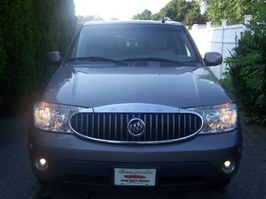

(199, 266, 3)

In [ ]:
N=0
N+=1
img = cv2.imread(data[N])
cv2_imshow(img)
img.shape

In [ ]:
os.makedirs(f'/content/dataset/', exist_ok=True)

counter = 0
for i in data[:4000]:
  for _ in range(6):
    counter += 1
    shutil.copyfile(i, f'/content/dataset/{counter}.jpg')

In [ ]:
dataset = glob.glob('/content/dataset/*.jpg')

In [ ]:
def max_pooling(img, pad_size=20):
  image = img[:, :, 0] + img[:, :, 1] + img[:, :, 2]
  max_pool_img = skimage.measure.block_reduce(image, (pad_size,pad_size), np.max)
  return max_pool_img

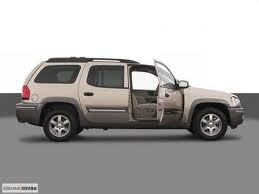

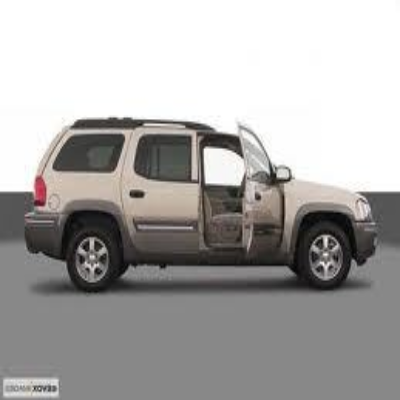

(20, 20)

In [ ]:
d = dataset[0]
img = cv2.imread(d)
cv2_imshow(img)
img = cv2.resize(img, (400, 400))
cv2_imshow(img)
img = max_pooling(img, pad_size=20)
cv2_imshow(img)
img.shape

In [ ]:
arr = []
for d in dataset:
  img = cv2.imread(d)
  img = cv2.resize(img, (400, 400))
  img = max_pooling(img, pad_size=25)
  img = np.ravel(img)
  arr.append(img)

In [ ]:
mse_arr = []
for i, A in enumerate(arr):
  temp = []
  for j, B in enumerate(arr):
    mse = ((A - B)**2).mean()
    if mse < 10 and i!=j:
      temp.append(dataset[j])
  mse_arr.append(temp)

In [ ]:
arr
#  [mse_arr[0]]
# dataset
# np.array(dataset).loc[3, 17, 42, 65, 101]
# dataset[3, 17]
# mse_arr
len(arr)

24000

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

# model.summary()
input = tf.keras.layers.Input(shape=(32, 32, 3))
net = model(input)
# keranet.summary()

#Part 3

In [ ]:
import os
import cv2
import glob
import tqdm
import skimage
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Path='.'
data = glob.glob(f'{Path}/*g')
videos = glob.glob(f'{Path}/*.mp4')
os.makedirs(f'{Path}/Videos/', exist_ok=True)
os.makedirs(f'{Path}/Images/', exist_ok=True)
for i, video_path in enumerate(videos):
    os.replace(video_path, f'{Path}/Videos/{i}.mp4')

In [ ]:
def min_pooling(img, pad_size=20):
  image = abs(img[:, :, 0] - img[:, :, 1] - img[:, :, 2])
  max_pool_img = skimage.measure.block_reduce(image, (pad_size,pad_size), np.mean)
  return max_pool_img

In [ ]:
arr = []
for d in tqdm.tqdm(data):
  try:
      img = cv2.imread(d)
      img = cv2.resize(img, (800, 800))
      img = min_pooling(img, pad_size=25)
      img = np.ravel(img)
      arr.append(img)
  except:
    print(d)

In [ ]:
mae_arr = []
for i, A in tqdm.tqdm(enumerate(arr)):
  temp = []
  mean_mae_arr = [(abs(A - b)).mean() for b in arr]
  for j, mae in enumerate(mean_mae_arr):
    if mae < 10:
        temp.append(data[j])
  mae_arr.append(temp)

In [ ]:
for id, path_list in tqdm.tqdm(enumerate(mae_arr)):
  if len(path_list) > 1:
    best_img, best_size= path_list[0], 0
    for n, p in enumerate(path_list):
        if os.path.exists(p):
            img = cv2.imread(p)
            img_size = img.shape[0] * img.shape[1]
            if img_size > best_size:
                best_img  = p
                best_size = img_size
    if os.path.exists(p):
        os.replace(best_img, f'{Path}/Images/img_{id}.jpg')
  else:
     p = path_list[0]
     if os.path.exists(p):
        os.replace(p, f'{Path}/Images/img_{id}.jpg')